In [14]:
"""
Required Packages: [
    "numpy(1.18.1)",
    "tensorflow(2.1.0)",
    "pandas(1.0.3)",
    "scikit-learn(0.22.2)",
    "PyKomoran(0.1.5)",
    "matplotlib(3.1.3)",
    "graphviz(0.14)",
    "pydot(1.4.1)"
]
"""

'\nRequired Packages: [\n    "numpy(1.18.1)",\n    "tensorflow(2.1.0)",\n    "pandas(1.0.3)",\n    "scikit-learn(0.22.2)",\n    "PyKomoran(0.1.5)",\n    "matplotlib(3.1.3)",\n    "graphviz(0.14)",\n    "pydot(1.4.1)"\n]\n'

In [15]:
import pandas as pd

articles = pd.read_csv('articles.tsv', sep='\t')
print(articles)

title  \
0    제주항공 "열흘내에 선행조건 다 해결해라"…사실상 파기수순   
1      이 앱 열면…한국 10대들 개인정보 중국으로 줄줄 샌다   
2  “예수가 레즈비언?” 마이클 잭슨 딸 출연 영화 신성모독 논란   

                                                body  
0  제주항공이 이스타항공 측에 "10일 이내에 선결 조건을 모두 이행하지 않으면 계약을...  
1  지난해 5월 미국 코네티컷주 한 마을에 거주하고 있는 14살 소녀 찰리 다멜리오는 ...  
2  마이클 잭슨의 딸 패리스 잭슨(22)이 ‘예수 그리스도’로 출연한 영화가 ‘신성 모...  


In [16]:
SOT = 'sot'
EOT = 'eot'

def pre_processing(text: str) -> str:
    return SOT + ' ' + text + ' ' + EOT

articles['title'] = articles['title'].apply(pre_processing)
articles['body'] = articles['body'].apply(pre_processing)
print(articles)

title  \
0    sot 제주항공 "열흘내에 선행조건 다 해결해라"…사실상 파기수순 eot   
1      sot 이 앱 열면…한국 10대들 개인정보 중국으로 줄줄 샌다 eot   
2  sot “예수가 레즈비언?” 마이클 잭슨 딸 출연 영화 신성모독 논란 eot   

                                                body  
0  sot 제주항공이 이스타항공 측에 "10일 이내에 선결 조건을 모두 이행하지 않으면...  
1  sot 지난해 5월 미국 코네티컷주 한 마을에 거주하고 있는 14살 소녀 찰리 다멜...  
2  sot 마이클 잭슨의 딸 패리스 잭슨(22)이 ‘예수 그리스도’로 출연한 영화가 ‘...  


In [17]:
from PyKomoran import Komoran
k = Komoran('EXP')

titles = [k.get_morphes_by_tags(title) for title in articles['title']]
print(titles[0][:20])

bodies = [k.get_morphes_by_tags(body) for body in articles['body']]
print(bodies[0][:20])

['sot', '제주항공', '"', '열흘', '내', '에', '선행', '조건', '다', '해결', '하', '아라', '"', '…', '사실', '상', '파기', '수순', 'eot']
['sot', '제주항공', '이', '이스타항공', '측', '에', '"', '10', '일', '이내', '에', '선결', '조건', '을', '모두', '이행', '하', '지', '않', '으면']


In [18]:
max_title_morphemes = max([len(title) for title in titles])
print(max_title_morphemes)

max_body_morphemes = max([len(body) for body in bodies])
print(max_body_morphemes)

data_size = len(titles)
print(data_size)

19
2002
3


In [19]:
from typing import List

def padding(lst: List[str], max_len: int) -> List[str]:
    return lst + [EOT] * (max_len - len(lst))

titles = [padding(title, max_title_morphemes) for title in titles]
print(titles[0][:20])

bodies = [padding(body, max_body_morphemes) for body in bodies]
print(bodies[0][:20])

['sot', '제주항공', '"', '열흘', '내', '에', '선행', '조건', '다', '해결', '하', '아라', '"', '…', '사실', '상', '파기', '수순', 'eot']
['sot', '제주항공', '이', '이스타항공', '측', '에', '"', '10', '일', '이내', '에', '선결', '조건', '을', '모두', '이행', '하', '지', '않', '으면']


In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(titles)
tokenizer.fit_on_texts(bodies)

num_of_morphemes = len(tokenizer.word_counts) + 1
print(num_of_morphemes)

title_sequence = np.array(tokenizer.texts_to_sequences(titles))
print(title_sequence)

body_sequence = np.array(tokenizer.texts_to_sequences(bodies))
print(body_sequence)

974
[[ 70  50  34 142  83   9 339  84   5  85   2 340  34 194 104  86 195 196
    1]
 [ 70   3 105 341  87 194 197 198  40 342  48  17 343 344  41   1   1   1
    1]
 [ 70  88  43  14 106 199 107 143 144  71  37 345  56   1   1   1   1   1
    1]]
[[ 70  50   3 ...   1   1   1]
 [ 70  75 119 ...   5   4   1]
 [ 70 143  10 ...   1   1   1]]


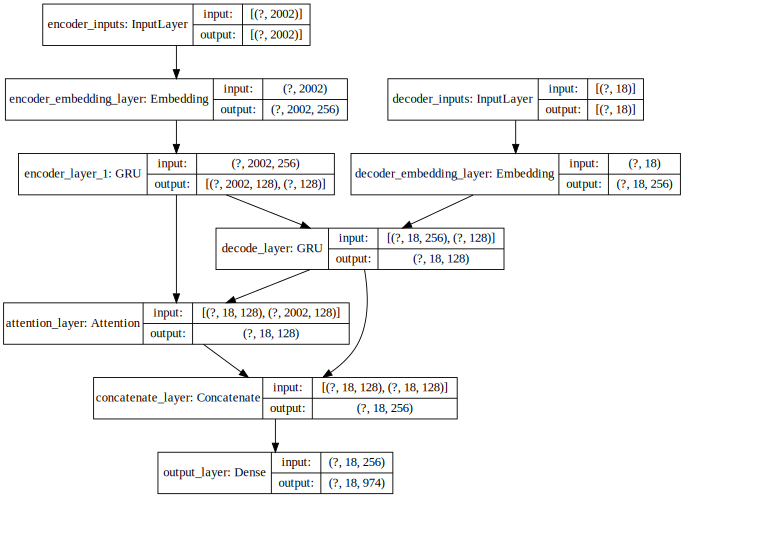

In [28]:
embedding_dim = 256
hidden_size = 128
encoder_layer_size = 1
learning_late = 0.001
dropout = 0.4

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Attention, Concatenate, Dense
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

# Encoder Input
encoder_inputs = Input(shape=(max_body_morphemes,), name='encoder_inputs')

# Encoder Embedding Layer
encoder_embedding = Embedding(
    num_of_morphemes, 
    embedding_dim, 
    name='encoder_embedding_layer'
)(encoder_inputs)

# Encoder Layer
encoder_outputs, encoder_states = None, None
for i in range(encoder_layer_size):
    encoder_layer = GRU(
        units=hidden_size,
        return_sequences=True, return_state=True,
        dropout=dropout, recurrent_dropout=dropout,
        name='encoder_layer_' + str(i + 1)
    )
    encoder_outputs, encoder_states = encoder_layer(
        encoder_embedding if encoder_outputs is None else encoder_outputs
    )

# Decoder
decoder_inputs = Input(shape=(max_title_morphemes - 1,), name='decoder_inputs')

# Decoder Embedding Layer
decoder_embedding_layer = Embedding(
    num_of_morphemes, 
    embedding_dim, 
    name='decoder_embedding_layer'
)
decoder_embedding = decoder_embedding_layer(decoder_inputs)

# Decoder Layer
decoder_layer = GRU(
    hidden_size,
    return_sequences=True,
    dropout=dropout, recurrent_dropout=dropout / 2,
    name='decode_layer'
)
decoder_outputs = decoder_layer(
    decoder_embedding,
    initial_state=encoder_states
)

# Attention Layer
attention_layer = Attention(name='attention_layer')
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])

# Concatenate the Result of Attention and the Hidden States of Decoder
decoder_concat_inputs = Concatenate(axis=-1, name='concatenate_layer')(
    [decoder_outputs, attention_outputs]
)

# Output Layer
output_layer = Dense(num_of_morphemes, activation=softmax, name='output_layer')
outputs = output_layer(decoder_concat_inputs)

# Define Model
model = Model(
    inputs=[encoder_inputs, decoder_inputs], 
    outputs=outputs,
    name='training_model'
)

# Compile
model.compile(
    optimizer=Adam(learning_rate=learning_late),
    loss=sparse_categorical_crossentropy
)

# Display Model Summary
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

# You need to install graphviz! (sudo apt install graphviz or brew install graphviz)
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [22]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    body_sequence, title_sequence, test_size=0.33
)
print(x_train)
print(x_test)
print(y_train)
print(y_test)

[[ 70 143  10 ...   1   1   1]
 [ 70  75 119 ...   5   4   1]]
[[70 50  3 ...  1  1  1]]
[[ 70  88  43  14 106 199 107 143 144  71  37 345  56   1   1   1   1   1
    1]
 [ 70   3 105 341  87 194 197 198  40 342  48  17 343 344  41   1   1   1
    1]]
[[ 70  50  34 142  83   9 339  84   5  85   2 340  34 194 104  86 195 196
    1]]


In [23]:
epochs = 5
batch_size = 1

history = model.fit(
    [x_train, y_train[:, :-1]], y_train[:, 1:],
    epochs=epochs, batch_size=batch_size,
    validation_data=([x_test, y_test[:, :-1]], y_test[:, 1:])
)

Train on 2 samples, validate on 1 samples
Epoch 1/5
2/2 [==============================] - 7s 4s/sample - loss: 6.8854 - val_loss: 6.8813
Epoch 2/5
2/2 [==============================] - 3s 2s/sample - loss: 6.8557 - val_loss: 6.8778
Epoch 3/5
2/2 [==============================] - 3s 2s/sample - loss: 6.8163 - val_loss: 6.8739
Epoch 4/5
2/2 [==============================] - 3s 2s/sample - loss: 6.7787 - val_loss: 6.8684
Epoch 5/5
2/2 [==============================] - 4s 2s/sample - loss: 6.7236 - val_loss: 6.8617


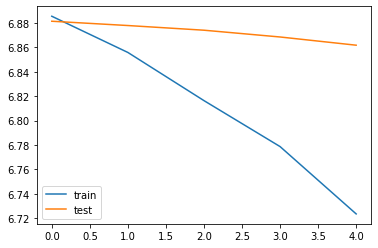

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

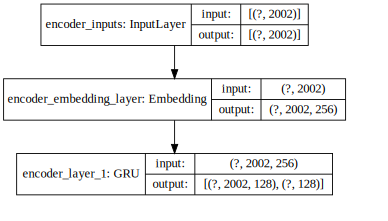

In [25]:
# Define Encoder Model
encoder_model = Model(
    inputs=encoder_inputs,
    outputs=[encoder_outputs, encoder_states],
    name='encoder_model'
)

# You need to install graphviz! (sudo apt install graphviz or brew install graphviz)
SVG(model_to_dot(encoder_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

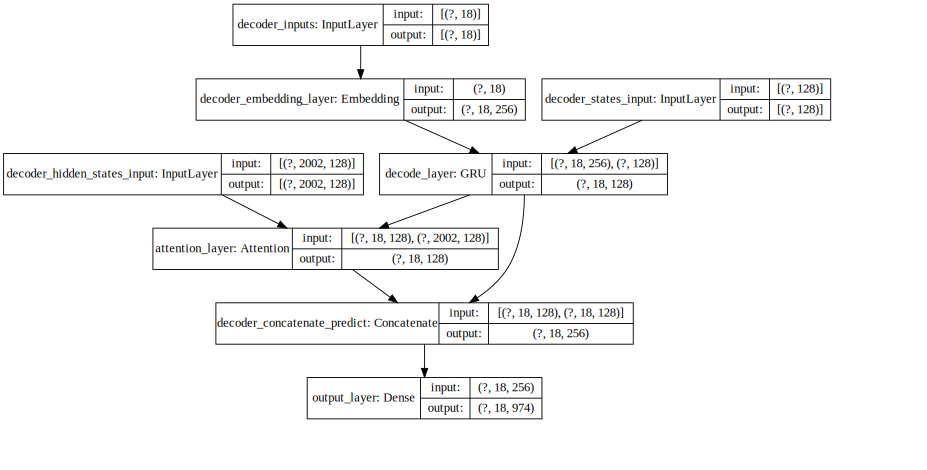

In [26]:
# Decoder
decoder_states_input = Input(
    shape=(hidden_size,),
    name='decoder_states_input'
)

decoder_embedding_predict = decoder_embedding_layer(decoder_inputs)
decoder_outputs_predict = decoder_layer(
    decoder_embedding_predict,
    initial_state=decoder_states_input
)

# Attention
decoder_hidden_states_input = Input(
    shape=(max_body_morphemes, hidden_size), 
    name='decoder_hidden_states_input'
)
attention_outputs_predict = attention_layer(
    [decoder_outputs_predict, decoder_hidden_states_input]
)
decoder_concat_predict = Concatenate(axis=-1, name='decoder_concatenate_predict')(
    [decoder_outputs_predict, attention_outputs_predict]
)

# Output Layer
outputs_predict = output_layer(decoder_concat_predict)

# Define Decoder Model
decoder_model = Model(
    [decoder_inputs, decoder_hidden_states_input, decoder_states_input],
    outputs_predict,
    name='decoder_model'
)

# You need to install graphviz! (sudo apt install graphviz or brew install graphviz)
SVG(model_to_dot(decoder_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [13]:
def encoding(text: str) -> np.ndarray:
    separated = k.get_morphes_by_tags(text)
    separated = padding(separated, max_body_morphemes)
    sequence = np.array(tokenizer.texts_to_sequences([separated]))
    return sequence

def predict(body: str) -> str:
    input_seq = encoding(body)
    e_out, e_h = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, max_title_morphemes - 1))
    target_seq[0, 0] = tokenizer.word_index[SOT]

    decoded_sentence = ''
    len_sentense = 0
    while True:
        output_tokens = decoder_model.predict(
            [target_seq, e_out, e_h]
        )
        sampled_token_index = np.argmax(output_tokens[0, len_sentense, 1:]) + 1
        sampled_token = tokenizer.index_word[sampled_token_index]

        if sampled_token != EOT:
            decoded_sentence += ' ' + sampled_token
            len_sentense += 1
        else:
            break

        if len_sentense >= max_title_morphemes - 1:
            break

        target_seq[0, len_sentense] = sampled_token_index

    return decoded_sentence

result = [predict(body) for body in articles['body']]
for i, title in enumerate(result):
    print('%-3d answer: \t' % i + articles['title'][i][4:-4])
    print('    predict: \t' + title)


0   answer: 	제주항공 "열흘내에 선행조건 다 해결해라"…사실상 파기수순
    predict: 	 사용 개봉 사용 짧 연구소 연구소 연구소 연구소 연구소 연구소 연구소 연구소 연구소 연구소 연구소 연구소 연구소 연구소
1   answer: 	이 앱 열면…한국 10대들 개인정보 중국으로 줄줄 샌다
    predict: 	 체불 이름 short 17 스럽 스럽 스럽 스럽 지급 빠르 갖 이어 이어 신자 데이터 그동안 6500 7800
2   answer: 	“예수가 레즈비언?” 마이클 잭슨 딸 출연 영화 신성모독 논란
    predict: 	 사용 개봉 사용 짧 연구소 연구소 연구소 연구소 연구소 연구소 연구소 연구소 연구소 연구소 연구소 연구소 연구소 연구소
